In [1]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
db = DocBin()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Sem"

/content/drive/MyDrive/Sem


In [4]:
import json

In [5]:
# Load the annotated data from a JSON file
data = json.load(open('/content/drive/MyDrive/Sem/annotation_dataset/annotation.json','r'))

In [6]:
len(data)

503

In [7]:
data[0]

['This 45-year-old African American male presents with a complaint of chronic lower back pain. He has a history of occasional back pain due to his job as a construction worker but reports that the pain has become more constant over the past six months. He has tried over-the-counter pain relievers like ibuprofen and acetaminophen, which provide temporary relief. He denies any recent injury or trauma. He has no known allergies. His weight is 210 pounds, and his blood pressure is 128/82. Examination reveals tenderness over the lumbar region with full range of motion but pain, and intact reflexes with no sensory deficits. Assessment is chronic lower back pain. Plan: Prescribe physical therapy twice a week for six weeks, continue ibuprofen as needed, consider imaging (MRI) if no improvement, and follow-up in 4 weeks.\r',
 {'entities': [[5, 16, 'AGE'],
   [34, 38, 'GENDER'],
   [68, 92, 'SYMPTOMS'],
   [113, 133, 'HISTORY'],
   [301, 310, 'MEDICINE'],
   [315, 328, 'MEDICINE'],
   [442, 452,

In [8]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

def get_spacy_doc(file, data):
    # Create a blank spaCy pipeline
    nlp = spacy.blank('en')
    db = DocBin()

    # Iterate through the data
    for item in tqdm(data):
        if isinstance(item, list) and len(item) == 2:
            item = tuple(item)  # Convert list to tuple if necessary

        if not isinstance(item, tuple) or len(item) != 2:
            print(f"Skipping invalid item: {item}")
            continue

        text, annot = item
        if not isinstance(annot, dict) or 'entities' not in annot:
            print(f"Invalid annotation format for item: {item}")
            continue

        doc = nlp.make_doc(text)
        ents = []
        entity_indices = []

        # Extract entities from the annotations
        for start, end, label in annot['entities']:
            if any(idx in entity_indices for idx in range(start, end)):
                continue

            entity_indices.extend(range(start, end))
            span = doc.char_span(start, end, label=label, alignment_mode='strict')

            if span is None:
                # Log errors for annotations that couldn't be processed
                err_data = f"[{start}, {end}]    {text}\n"
                file.write(err_data)
            else:
                ents.append(span)

        try:
            doc.ents = ents
            db.add(doc)
        except Exception as e:
            print(f"Error adding doc to DocBin: {e}")
            continue

    return db


In [9]:
# Split the annotated data into training and testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

# Display the number of items in the training and testing sets
len(train), len(test)






(402, 101)

In [10]:
file = open('/content/drive/MyDrive/Sem/trained_models/train_file.txt','w')

In [11]:
db = get_spacy_doc(file, train)
db.to_disk('/content/drive/MyDrive/Sem/trained_models/train_data.spacy')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 402/402 [00:00<00:00, 1782.64it/s]

Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None


In [12]:
db = get_spacy_doc(file, test)
db.to_disk('/content/drive/MyDrive/Sem/trained_models/test_data.spacy')

100%|██████████| 101/101 [00:00<00:00, 1422.34it/s]


Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None
Skipping invalid item: None


In [13]:
file.close()

In [14]:
!python -m spacy train /content/drive/MyDrive/Sem/config/config.cfg  --output /content/drive/MyDrive/Sem/trained_models/output  --paths.train /content/drive/MyDrive/Sem/trained_models/train_data.spacy  --paths.dev /content/drive/MyDrive/Sem/trained_models/test_data.spacy --gpu-id 0

ℹ Saving to output directory:
/content/drive/MyDrive/Sem/trained_models/output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.95    0.00    0.00    0.00    0.00
  1     200       2808.51   3771.21   55.07   60.00   50.89    0.55
  2     400        171.93   1704.91   59.93   59.11   60.76    0.60
  3     600        529.90   1631.41   66.32   68.18   64.56    0.66
  5     800        358.84   1756.72   68.41   70.62   66.33    0.68
  7    1000        429.50   2020.64   69.31   72.58   66.33    0.69
  9    1200        399.60   2143.08   68.44   71.87   65.32    0.68
 13    1400       3689.99   2365.31   69.42   68.73   

In [17]:
nlp = spacy.load('/content/drive/MyDrive/Sem/trained_models/output/model-best')


In [18]:
doc=nlp("SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,Lungs:  Clear.,ASSESSMENT:,  Allergic rhinitis.,PLAN:,1.  She will try Zyrtec instead of Allegra again.  Another option will be to use loratadine.  She does not think she has prescription coverage so that might be cheaper.,2.  Samples of Nasonex two sprays in each nostril given for three weeks.  A prescription was written as well.")

In [19]:
entities=[]
for entity in doc.ents:
  entities.append({"Entity": entity.label_,"Text": entity.text})
print(entities)

[{'Entity': 'AGE', 'Text': '23-year-old'}, {'Entity': 'GENDER', 'Text': 'female'}, {'Entity': 'SYMPTOMS', 'Text': 'Zyrtec.'}, {'Entity': 'WEIGHT', 'Text': '130 pounds'}]


In [20]:
import pandas as pd

# Initialize a dictionary to hold the data for the DataFrame
data = {}

# Process each entity in the extracted entities list
for entity in entities:
    entity_type = entity['Entity']
    entity_value = entity['Text']

    # If the entity type is not already in the data, add it
    if entity_type not in data:
        data[entity_type] = []

    # Append the entity value to the corresponding list in the data
    data[entity_type].append(entity_value)

# Determine the maximum length of the lists to balance the DataFrame
max_length = max(len(values) for values in data.values())

# Normalize the lengths of the lists in the data dictionary
for key in data:
    if len(data[key]) < max_length:
        data[key].extend([None] * (max_length - len(data[key])))

# Convert the data dictionary to a Pandas DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

# Optionally, save the DataFrame to a CSV file
df.to_csv('dynamic_structured_data.csv', index=False)

           AGE  GENDER SYMPTOMS      WEIGHT
0  23-year-old  female  Zyrtec.  130 pounds


In [21]:
colors={"Age=":"#F67DE3","Gender":"#e6194B","Medicine":"#3cb44b"}
options={"colors":colors}
spacy.displacy.render(doc, style="ent",options=options, jupyter=True) # display in Jupyter

In [23]:
import spacy
from spacy.training import Example
from spacy.scorer import Scorer

# Load the trained model
nlp = spacy.load('/content/drive/MyDrive/Sem/trained_models/output/model-best')
scorer = Scorer()

examples = []

for item in test:
    # Skip None values
    if item is None:
        continue

    # Ensure item is a list with the correct structure
    if isinstance(item, list) and len(item) == 2 and isinstance(item[0], str) and isinstance(item[1], dict):
        text = item[0]
        entities_dict = item[1]

        if 'entities' in entities_dict:
            entities = entities_dict['entities']

            # Convert entities to the required format
            annots = [(start, end, label) for start, end, label in entities]

            # Get the predicted Doc object from the model
            predicted = nlp(text)

            # Create the reference annotation dictionary
            final = {'entities': annots}

            # Create an Example object
            example = Example.from_dict(predicted, final)
            examples.append(example)
        else:
            print(f"Skipping item with missing 'entities' key: {item}")
    else:
        print(f"Skipping invalid item: {item}")

# Score the examples
scores = scorer.score(examples)
print(scores['ents_per_type'])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


{'AGE': {'p': 1.0, 'r': 0.98, 'f': 0.98989898989899}, 'GENDER': {'p': 0.8653846153846154, 'r': 0.9574468085106383, 'f': 0.9090909090909091}, 'SYMPTOMS': {'p': 0.5853658536585366, 'r': 0.5783132530120482, 'f': 0.5818181818181818}, 'WEIGHT': {'p': 0.9210526315789473, 'r': 0.9210526315789473, 'f': 0.9210526315789473}, 'BP': {'p': 0.8333333333333334, 'r': 0.9090909090909091, 'f': 0.8695652173913043}, 'DISEASE': {'p': 0.4, 'r': 0.2926829268292683, 'f': 0.3380281690140845}, 'HISTORY': {'p': 0.5714285714285714, 'r': 0.5454545454545454, 'f': 0.5581395348837208}, 'MEDICINE': {'p': 0.6666666666666666, 'r': 0.6451612903225806, 'f': 0.6557377049180327}, 'DOSAGE': {'p': 0.4782608695652174, 'r': 0.4230769230769231, 'f': 0.44897959183673475}, 'FOLLOWUP': {'p': 0.5357142857142857, 'r': 0.625, 'f': 0.576923076923077}}


Precision: 0.712082262210797
Recall: 0.7012658227848101
F1-score: 0.7066326530612245


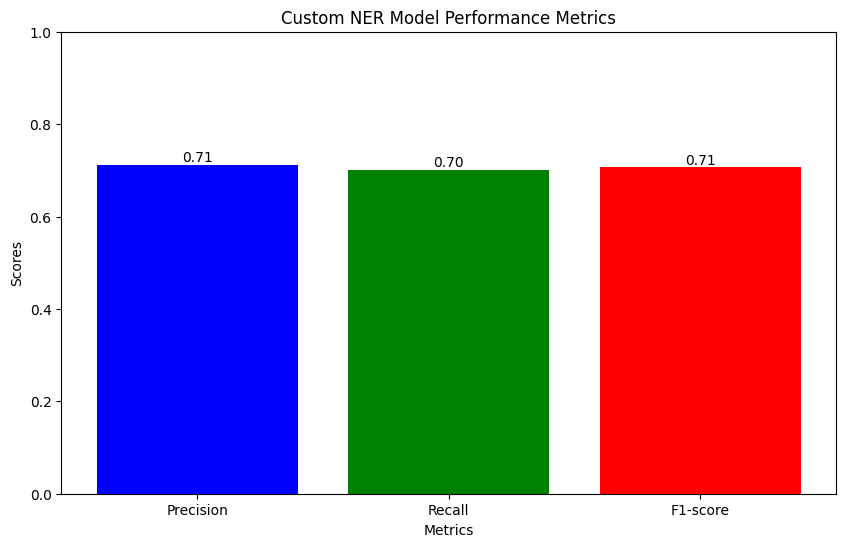

In [24]:
import matplotlib.pyplot as plt
precision = scores["ents_p"]
recall = scores["ents_r"]
f1_score = scores["ents_f"]

# Print overall metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Plot the metrics
metrics = [precision, recall, f1_score]
metrics_names = ["Precision", "Recall", "F1-score"]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Custom NER Model Performance Metrics')
plt.ylim(0, 1)
for index, value in enumerate(metrics):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')
plt.show()